In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import corner
import pandas as pd
from numba import njit

# --- FIXED COSMOLOGICAL PARAMETERS (for w0waCDM calculation) ---
# These are kept fixed as commonly done in analyses or assumed for r_d calculation.
OMEGA_B_FIXED_W0WA = 0.048 # A typical Planck/BBN value for Omega_b
OMEGA_K_FIXED = 0.0   # Flat universe assumed
Neff_fixed_W0WA = 3.044 # Standard effective number of relativistic species
# --- Constants ---
c_W0WA = 299792.458 # km/s (speed of light)

In [3]:
import numpy as np
import pandas as pd

# -----------------------------
# Load Pantheon+ Data
# -----------------------------
# Ensure these files are in your project directory:
# Pantheon+SH0ES.dat
# Pantheon+SH0ES_STAT+SYS.cov
df = pd.read_csv("Pantheon+SH0ES.dat", sep=r'\s+', comment='#') 
original_full_df_indices = df[df['USED_IN_SH0ES_HF'] == 1].index.values
df_filtered = df[df['USED_IN_SH0ES_HF'] == 1].reset_index(drop=True)

# These variables will be used globally by likelihood functions
z = df_filtered['zHD'].values
mu_obs = df_filtered['MU_SH0ES'].values

with open("Pantheon+SH0ES_STAT+SYS.cov") as f:
    N = int(f.readline())  
    flat_cov = np.loadtxt(f)
    cov_all = flat_cov.reshape((N, N))
cov = cov_all[np.ix_(original_full_df_indices, original_full_df_indices)]
jitter = 1e-9 * np.eye(cov.shape[0])
inv_cov = np.linalg.inv(cov + jitter)
print("✅ Pantheon+ Data Loaded.")

# -----------------------------
# Load DESI BAO Data
# -----------------------------
# Ensure these files are in your project directory:
# desi_2024_gaussian_bao_ALL_GCcomb_mean.txt
# desi_2024_gaussian_bao_ALL_GCcomb_cov.txt
desi_mean_file = "desi_2024_gaussian_bao_ALL_GCcomb_mean.txt"
desi_cov_file = "desi_2024_gaussian_bao_ALL_GCcomb_cov.txt"

desi_data_raw = pd.read_csv(desi_mean_file, sep=r'\s+', comment='#', header=None,
                            names=['z_eff', 'value', 'quantity_type'])

# These variables will be used globally by likelihood functions
z_eff_desi = desi_data_raw['z_eff'].values
observed_values_desi = desi_data_raw['value'].values
quantity_types_desi = desi_data_raw['quantity_type'].values

cov_desi_flat = np.loadtxt(desi_cov_file)
N_desi = len(observed_values_desi)
cov_desi = cov_desi_flat.reshape((N_desi, N_desi))
jitter_desi = 1e-9 * np.eye(cov_desi.shape[0])
inv_cov_desi = np.linalg.inv(cov_desi + jitter_desi)
print("✅ DESI BAO Data Loaded.")

✅ Pantheon+ Data Loaded.
✅ DESI BAO Data Loaded.


In [15]:
import numpy as np
from scipy.integrate import quad
from numba import njit # Make sure Numba is imported

# --- FIXED COSMOLOGICAL PARAMETERS (from Cell 1) ---
# Ensure these are defined in a prior cell, or redefine them here for standalone testing
# OMEGA_B_FIXED_W0WA = 0.048 
# OMEGA_K_FIXED = 0.0   
# Neff_fixed_W0WA = 3.044 
# c_W0WA = 299792.458 

# --- Define the Dark Energy Evolution Factor g(z) for CPL parametrization ---
@njit # Keep njit: it's pure numerical Python
def g_z_CPL(z_val, w0, wa):
    a = 1.0 / (1.0 + z_val)
    if a <= 0:
        return 0.0 
    return a**(-3.0 * (1.0 + w0 + wa)) * np.exp(-3.0 * wa * (1.0 - a))

# --- Hubble Parameter H(z) for Flat w0waCDM ---
@njit # Keep njit: it's pure numerical Python
def H_z_W0WA(z_val, H0, Omega_m, w0, wa):
    Omega_de0 = 1 - Omega_m
    if Omega_de0 < 0 or Omega_m < 0: 
        return np.inf 
    term_in_sqrt = Omega_m * (1.0 + z_val)**3 + Omega_de0 * g_z_CPL(z_val, w0, wa)
    if term_in_sqrt <= 0:
        return np.inf
    return H0 * np.sqrt(term_in_sqrt)

# --- Integrand for D_M_th_W0WA ---
# This integrand is pure numerical Python, so it can be jitted.
@njit 
def E_inv_for_DM_w0wa_integrand_numba(z_prime, H0, Omega_m, w0, wa):
    Hz_prime = H_z_W0WA(z_prime, H0, Omega_m, w0, wa)
    if not np.isfinite(Hz_prime) or Hz_prime == 0:
        return np.nan 
    return H0 / Hz_prime

# --- D_M_th, D_H_th, D_V_th for w0waCDM ---
# REMOVED @njit here: This function calls scipy.integrate.quad, which is not Numba-compatible.
def D_M_th_W0WA(z_val, H0, Omega_m, w0, wa):
    if isinstance(z_val, np.ndarray):
        integral_results = np.array([quad(E_inv_for_DM_w0wa_integrand_numba, 0, zi, args=(H0, Omega_m, w0, wa))[0] for zi in z_val])
    else: 
        integral_results = quad(E_inv_for_DM_w0wa_integrand_numba, 0, z_val, args=(H0, Omega_m, w0, wa))[0]
    
    if not np.all(np.isfinite(integral_results)):
        return -np.inf 
        
    return (c_W0WA / H0) * integral_results

@njit # Keep njit: it's pure numerical Python
def D_H_th_W0WA(z_val, H0, Omega_m, w0, wa):
    Hz_val = H_z_W0WA(z_val, H0, Omega_m, w0, wa)
    if not np.isfinite(Hz_val) or Hz_val == 0:
        return np.inf 
    return c_W0WA / Hz_val

# REMOVED @njit here: This function calls D_M_th_W0WA, which is not jitted.
def D_V_th_W0WA(z_val, H0, Omega_m, w0, wa):
    dm_val = D_M_th_W0WA(z_val, H0, Omega_m, w0, wa) 
    dh_val = D_H_th_W0WA(z_val, H0, Omega_m, w0, wa)
    
    if not np.all(np.isfinite(dm_val)) or not np.all(np.isfinite(dh_val)):
        return np.inf

    inner_val = z_val * dm_val**2 * dh_val
    if inner_val < 0:
        return np.inf 
        
    return inner_val**(1/3.0)

@njit # Keep njit: it's pure numerical Python
def r_d_th_W0WA(H0, Omega_m, Omega_b):
    h = H0 / 100.0
    ombh2_calc = Omega_b * h**2 
    omch2_calc = Omega_m * h**2 - ombh2_calc 

    if not (ombh2_calc > 0.005 and omch2_calc > 0): 
        return np.inf 
        
    omegamh2_calc = Omega_m * h**2 
    if not (omegamh2_calc > 0):
        return np.inf

    rd = 147.05 * (ombh2_calc / 0.02236)**(-0.13) * \
         (omegamh2_calc / 0.1432)**(-0.23) * \
         (Neff_fixed_W0WA / 3.04)**(-0.1)
    return rd

In [17]:
import numpy as np

# REMOVED @njit here: This function calls D_M_th_W0WA, which is not jitted.
def distance_modulus_W0WA(z_val, H0, Omega_m, w0, wa):
    dL = (1.0 + z_val) * D_M_th_W0WA(z_val, H0, Omega_m, w0, wa)
    if not np.all(np.isfinite(dL)): 
        return np.inf
    return 5 * np.log10(dL + 1e-10) + 25

# REMOVED @njit here: This likelihood calls distance_modulus_W0WA, which is not jitted.
def log_likelihood_pantheon_w0wa(theta, z_data, mu_obs_data, inv_cov_data):
    H0, Omega_m, w0, wa = theta 
    
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8):
        return -np.inf 
    
    if not (-3 < w0 < 1 and -3 < wa < 2):
        return -np.inf
    
    if w0 + wa >= 0:
        return -np.inf

    mu_th = distance_modulus_W0WA(z_data, H0, Omega_m, w0, wa)
    
    if not np.all(np.isfinite(mu_th)):
        return -np.inf
    
    delta = mu_obs_data - mu_th
    chi2 = delta @ inv_cov_data @ delta 
    
    return -0.5 * chi2

# REMOVED @njit here: This likelihood calls D_V_th_W0WA/D_M_th_W0WA, which are not fully jitted.
def log_likelihood_desi_w0wa(theta, z_eff_desi_data, observed_values_desi_data, quantity_types_desi_data, inv_cov_desi_data):
    H0, Omega_m, w0, wa = theta 
    
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8 and -3 < w0 < 1 and -3 < wa < 2): 
        return -np.inf 

    if w0 + wa >= 0: 
        return -np.inf

    rd_model = r_d_th_W0WA(H0, Omega_m, OMEGA_B_FIXED_W0WA)
    if not np.isfinite(rd_model): 
        return -np.inf

    predicted_values_list = []
    for i, quantity_type in enumerate(quantity_types_desi_data):
        z_val = z_eff_desi_data[i] 
        
        val = np.nan 
        if quantity_type == 'DV_over_rs':
            val = D_V_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        elif quantity_type == 'DM_over_rs':
            val = D_M_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        elif quantity_type == 'DH_over_rs':
            val = D_H_th_W0WA(z_val, H0, Omega_m, w0, wa) / rd_model
        
        if not np.isfinite(val):
            return -np.inf
            
        predicted_values_list.append(val)
        
    predicted_values_desi = np.array(predicted_values_list)
    
    delta_desi = observed_values_desi_data - predicted_values_desi
    chi2_desi = delta_desi @ inv_cov_desi_data @ delta_desi
    
    return -0.5 * chi2_desi

🔁 Running MCMC for Pantheon+ (w0waCDM)...


100%|██████████| 15000/15000 [1:19:18<00:00,  3.15it/s]  


✅ MCMC for Pantheon+ (w0waCDM) completed!
Shape of processed Pantheon+ (w0waCDM) samples: (76800, 4)


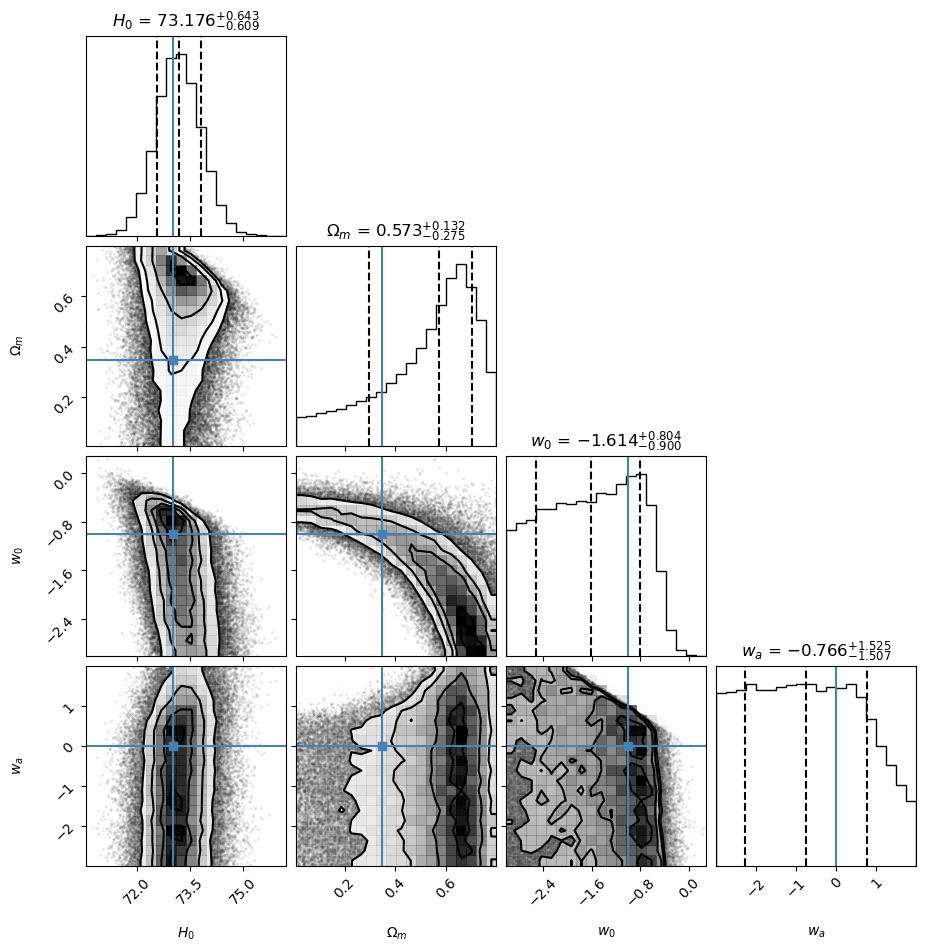


📊 Pantheon+ (w0waCDM) Best-fit H0 = 73.18 +0.64 -0.61 km/s/Mpc
📊 Pantheon+ (w0waCDM) Best-fit Omega_m = 0.573 +0.132 -0.275
📊 Pantheon+ (w0waCDM) Best-fit w0 = -1.614 +0.804 -0.900
📊 Pantheon+ (w0waCDM) Best-fit wa = -0.766 +1.525 -1.507

Average Pantheon+ (w0waCDM) acceptance fraction: 0.44
Total Pantheon+ (w0waCDM) samples in chain: 960000
Number of processed Pantheon+ (w0waCDM) samples: 76800


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for Pantheon+ with w0waCDM ---
ndim_pantheon_w0wa = 4 
nwalkers_pantheon_w0wa = 64 
nsteps_pantheon_w0wa = 15000 
burn_in_pantheon_w0wa = 3000 
thin_factor_pantheon_w0wa = 10

initial_guess_pantheon_w0wa = np.array([73.0, 0.35, -1.0, 0.0]) 
pos_pantheon_w0wa = initial_guess_pantheon_w0wa + 1e-3 * np.random.randn(nwalkers_pantheon_w0wa, ndim_pantheon_w0wa)

# Data arguments for Pantheon+ likelihood
data_args_pantheon_w0wa = (z, mu_obs, inv_cov)

sampler_pantheon_w0wa = emcee.EnsembleSampler(nwalkers_pantheon_w0wa, ndim_pantheon_w0wa, 
                                               log_likelihood_pantheon_w0wa,
                                               args=data_args_pantheon_w0wa)

print("🔁 Running MCMC for Pantheon+ (w0waCDM)...")
sampler_pantheon_w0wa.run_mcmc(pos_pantheon_w0wa, nsteps_pantheon_w0wa, progress=True)
print("✅ MCMC for Pantheon+ (w0waCDM) completed!")

# --- PROCESS and PLOT POSTERIOR for Pantheon+ with w0waCDM ---
samples_pantheon_w0wa = sampler_pantheon_w0wa.get_chain(discard=burn_in_pantheon_w0wa, thin=thin_factor_pantheon_w0wa, flat=True)

print(f"Shape of processed Pantheon+ (w0waCDM) samples: {samples_pantheon_w0wa.shape}")

fig_pantheon_w0wa = corner.corner(samples_pantheon_w0wa, labels=[r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$"],
                                  truths=initial_guess_pantheon_w0wa, 
                                  show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("pantheon_w0wa_mcmc_corner.png", dpi=300, format='png')
plt.show()

h0_pw0wa = np.percentile(samples_pantheon_w0wa[:, 0], [16, 50, 84])
omega_m_pw0wa = np.percentile(samples_pantheon_w0wa[:, 1], [16, 50, 84])
w0_pw0wa = np.percentile(samples_pantheon_w0wa[:, 2], [16, 50, 84])
wa_pw0wa = np.percentile(samples_pantheon_w0wa[:, 3], [16, 50, 84])

print(f"\n📊 Pantheon+ (w0waCDM) Best-fit H0 = {h0_pw0wa[1]:.2f} +{h0_pw0wa[2]-h0_pw0wa[1]:.2f} -{h0_pw0wa[1]-h0_pw0wa[0]:.2f} km/s/Mpc")
print(f"📊 Pantheon+ (w0waCDM) Best-fit Omega_m = {omega_m_pw0wa[1]:.3f} +{omega_m_pw0wa[2]-omega_m_pw0wa[1]:.3f} -{omega_m_pw0wa[1]-omega_m_pw0wa[0]:.3f}")
print(f"📊 Pantheon+ (w0waCDM) Best-fit w0 = {w0_pw0wa[1]:.3f} +{w0_pw0wa[2]-w0_pw0wa[1]:.3f} -{w0_pw0wa[1]-w0_pw0wa[0]:.3f}")
print(f"📊 Pantheon+ (w0waCDM) Best-fit wa = {wa_pw0wa[1]:.3f} +{wa_pw0wa[2]-wa_pw0wa[1]:.3f} -{wa_pw0wa[1]-wa_pw0wa[0]:.3f}")

print(f"\nAverage Pantheon+ (w0waCDM) acceptance fraction: {np.mean(sampler_pantheon_w0wa.acceptance_fraction):.2f}")
print(f"Total Pantheon+ (w0waCDM) samples in chain: {nwalkers_pantheon_w0wa * nsteps_pantheon_w0wa}")
print(f"Number of processed Pantheon+ (w0waCDM) samples: {samples_pantheon_w0wa.shape[0]}")

🔁 Running MCMC for DESI BAO (w0waCDM)...


100%|██████████| 25000/25000 [04:31<00:00, 92.00it/s]


✅ MCMC for DESI BAO (w0waCDM) completed!
Shape of processed DESI BAO (w0waCDM) samples: (128000, 4)


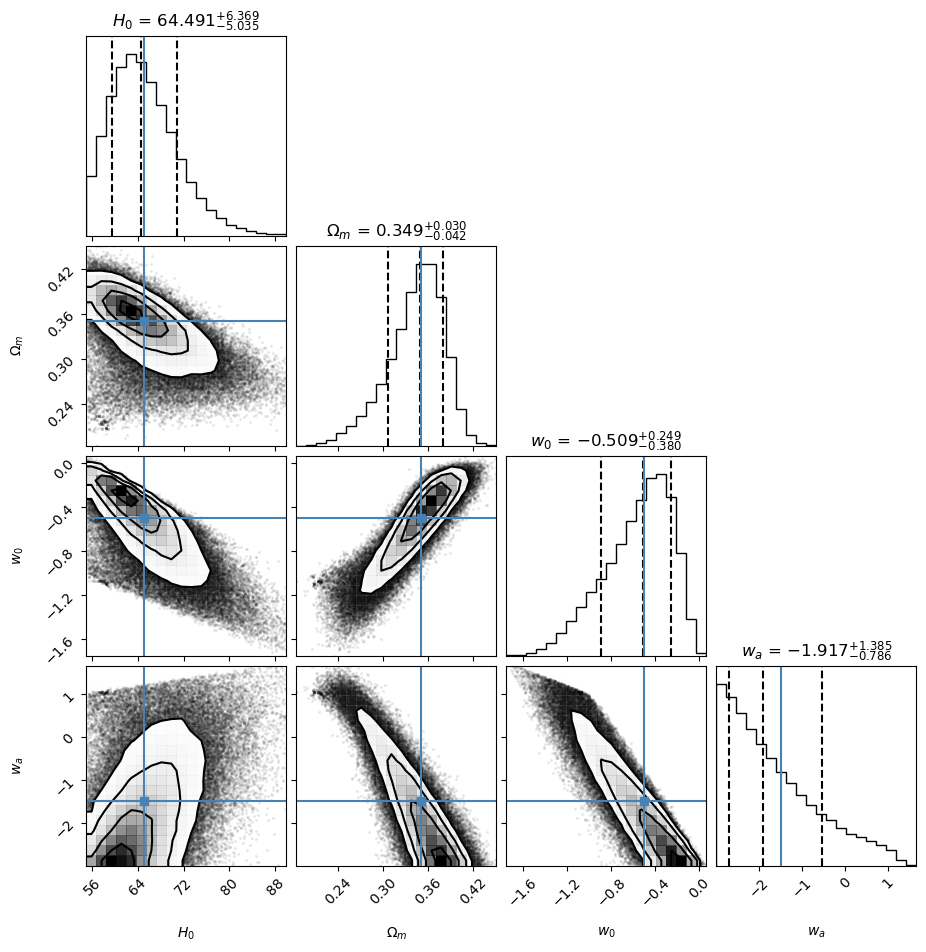


📊 DESI BAO (w0waCDM) Best-fit H0 = 64.49 +6.37 -5.04 km/s/Mpc
📊 DESI BAO (w0waCDM) Best-fit Omega_m = 0.349 +0.030 -0.042
📊 DESI BAO (w0waCDM) Best-fit w0 = -0.509 +0.249 -0.380
📊 DESI BAO (w0waCDM) Best-fit wa = -1.917 +1.385 -0.786


NameError: name 'sampler_dw0wa' is not defined

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC SETUP and RUN for DESI BAO with w0waCDM ---
ndim_desi_w0wa = 4 # H0, Omega_m, w0, wa
nwalkers_desi_w0wa = 64 
nsteps_desi_w0wa = 25000 
burn_in_desi_w0wa = 5000 
thin_factor_desi_w0wa = 10

initial_guess_desi_w0wa = np.array([65.0, 0.35, -0.5, -1.5]) 
pos_desi_w0wa = initial_guess_desi_w0wa + 1e-4 * np.random.randn(nwalkers_desi_w0wa, ndim_desi_w0wa) 

# Data arguments for DESI BAO likelihood
data_args_desi_w0wa = (z_eff_desi, observed_values_desi, quantity_types_desi, inv_cov_desi)

sampler_desi_w0wa = emcee.EnsembleSampler(nwalkers_desi_w0wa, ndim_desi_w0wa, 
                                          log_likelihood_desi_w0wa, 
                                          args=data_args_desi_w0wa)

print("🔁 Running MCMC for DESI BAO (w0waCDM)...")
sampler_desi_w0wa.run_mcmc(pos_desi_w0wa, nsteps_desi_w0wa, progress=True)
print("✅ MCMC for DESI BAO (w0waCDM) completed!")

# --- PROCESS and PLOT POSTERIOR for DESI BAO with w0waCDM ---
samples_desi_w0wa = sampler_desi_w0wa.get_chain(discard=burn_in_desi_w0wa, thin=thin_factor_desi_w0wa, flat=True)

print(f"Shape of processed DESI BAO (w0waCDM) samples: {samples_desi_w0wa.shape}")

fig_desi_w0wa = corner.corner(samples_desi_w0wa, labels=[r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$"],
                                  truths=initial_guess_desi_w0wa, 
                                  show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("desi_w0wa_mcmc_corner.png", dpi=300, format='png')
plt.show()

h0_dw0wa = np.percentile(samples_desi_w0wa[:, 0], [16, 50, 84])
omega_m_dw0wa = np.percentile(samples_desi_w0wa[:, 1], [16, 50, 84])
w0_dw0wa = np.percentile(samples_desi_w0wa[:, 2], [16, 50, 84])
wa_dw0wa = np.percentile(samples_desi_w0wa[:, 3], [16, 50, 84])

print(f"\n📊 DESI BAO (w0waCDM) Best-fit H0 = {h0_dw0wa[1]:.2f} +{h0_dw0wa[2]-h0_dw0wa[1]:.2f} -{h0_dw0wa[1]-h0_dw0wa[0]:.2f} km/s/Mpc")
print(f"📊 DESI BAO (w0waCDM) Best-fit Omega_m = {omega_m_dw0wa[1]:.3f} +{omega_m_dw0wa[2]-omega_m_dw0wa[1]:.3f} -{omega_m_dw0wa[1]-omega_m_dw0wa[0]:.3f}")
print(f"📊 DESI BAO (w0waCDM) Best-fit w0 = {w0_dw0wa[1]:.3f} +{w0_dw0wa[2]-w0_dw0wa[1]:.3f} -{w0_dw0wa[1]-w0_dw0wa[0]:.3f}")
print(f"📊 DESI BAO (w0waCDM) Best-fit wa = {wa_dw0wa[1]:.3f} +{wa_dw0wa[2]-wa_dw0wa[1]:.3f} -{wa_dw0wa[1]-wa_dw0wa[0]:.3f}")

print(f"\nAverage DESI BAO (w0waCDM) acceptance fraction: {np.mean(sampler_desi_w0wa.acceptance_fraction):.2f}")
print(f"Total DESI BAO (w0waCDM) samples in chain: {nwalkers_desi_w0wa * nsteps_desi_w0wa}")
print(f"Number of processed DESI BAO (w0waCDM) samples: {samples_desi_w0wa.shape[0]}")

🔁 Running 4D MCMC (H0, Omega_m, w0, wa) for Combined Pantheon+ & DESI BAO with Numba optimization...


100%|██████████| 25000/25000 [2:42:44<00:00,  2.56it/s]  


✅ 4D MCMC for Combined data completed!
Shape of processed 4D combined w0wa samples: (256000, 4)


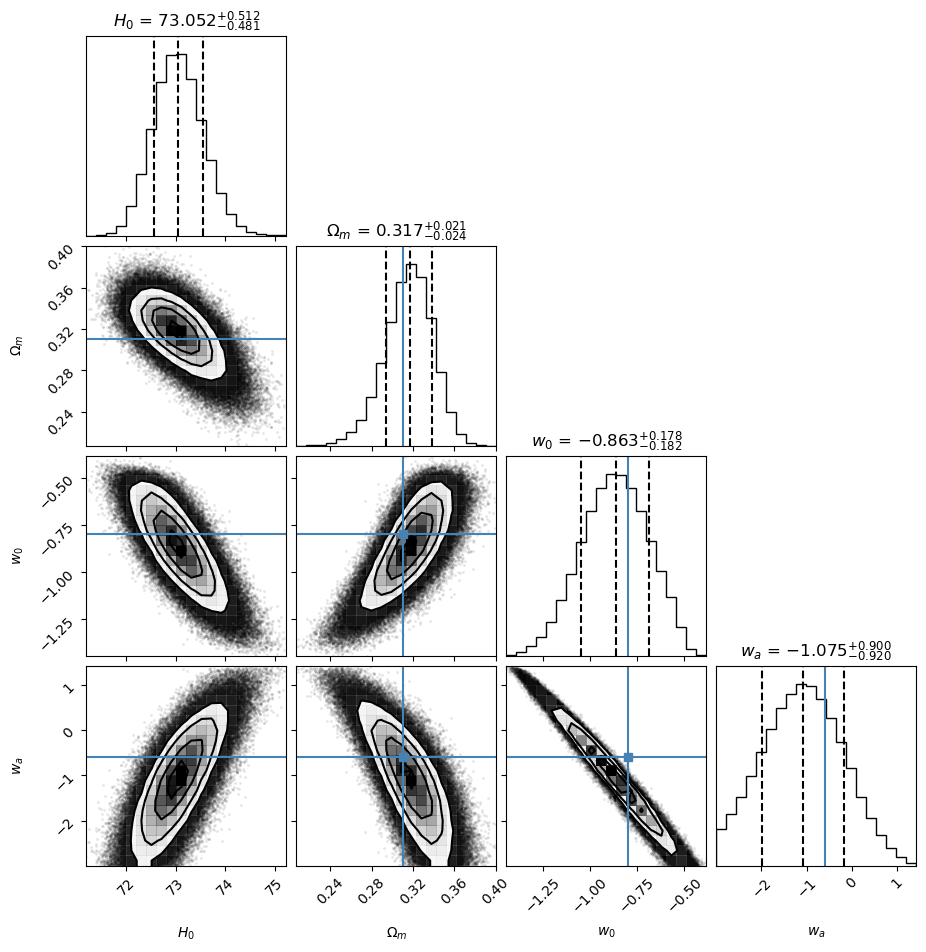


📊 Combined (w0waCDM) Best-fit H0 = 73.05 +0.51 -0.48 km/s/Mpc
📊 Combined (w0waCDM) Best-fit Omega_m = 0.317 +0.021 -0.024
📊 Combined (w0waCDM) Best-fit w0 = -0.863 +0.178 -0.182
📊 Combined (w0waCDM) Best-fit wa = -1.075 +0.900 -0.920

Average Combined (w0waCDM) acceptance fraction: 0.59
Total Combined (w0waCDM) samples in chain: 3200000
Number of processed Combined (w0waCDM) samples: 256000


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# REMOVED @njit here: This likelihood calls other non-jitted likelihoods.
def log_likelihood_combined_w0wa_final(theta, z_pantheon, mu_obs_pantheon, inv_cov_pantheon, 
                                        z_eff_desi, obs_values_desi, qty_types_desi, inv_cov_desi):
    H0, Omega_m, w0, wa = theta 

    lp_pantheon = log_likelihood_pantheon_w0wa(theta, z_pantheon, mu_obs_pantheon, inv_cov_pantheon)
    
    if not np.isfinite(lp_pantheon):
        return -np.inf
        
    lp_desi = log_likelihood_desi_w0wa(theta, z_eff_desi, obs_values_desi, qty_types_desi, inv_cov_desi)
    
    if not np.isfinite(lp_desi):
        return -np.inf
        
    return lp_pantheon + lp_desi

# -----------------------------
# MCMC setup for Combined Data (4D: H0, Omega_m, w0, wa)
# -----------------------------
ndim_combined_w0wa = 4          # Number of dimensions: H0, Omega_m, w0, wa
nwalkers_combined_w0wa = 128    # Number of parallel chains (>= 2*ndim)
nsteps_combined_w0wa = 25000    # Total number of steps per walker (increased for 4D)
burn_in_combined_w0wa = 5000    # Steps to discard for burn-in
thin_factor_combined_w0wa = 10  # Thinning factor for samples

# Initial guess for the 4 parameters
initial_guess_combined_w0wa = np.array([67.5, 0.31, -0.8, -0.6]) 
pos_combined_w0wa = initial_guess_combined_w0wa + 1e-4 * np.random.randn(nwalkers_combined_w0wa, ndim_combined_w0wa) 

# --- Prepare Data Arguments to Pass to Sampler ---
data_args_for_sampler = (z, mu_obs, inv_cov, 
                         z_eff_desi, observed_values_desi, quantity_types_desi, inv_cov_desi)

print("🔁 Running 4D MCMC (H0, Omega_m, w0, wa) for Combined Pantheon+ & DESI BAO with Numba optimization...")

# Initialize the emcee sampler, passing the data arguments
sampler_combined_w0wa = emcee.EnsembleSampler(nwalkers_combined_w0wa, ndim_combined_w0wa, 
                                            log_likelihood_combined_w0wa_final, 
                                            args=data_args_for_sampler)

# Run the MCMC
sampler_combined_w0wa.run_mcmc(pos_combined_w0wa, nsteps_combined_w0wa, progress=True)

print("✅ 4D MCMC for Combined data completed!")

# --- PROCESS and PLOT POSTERIOR (4D) ---
samples_combined_w0wa = sampler_combined_w0wa.get_chain(discard=burn_in_combined_w0wa, thin=thin_factor_combined_w0wa, flat=True)

print(f"Shape of processed 4D combined w0wa samples: {samples_combined_w0wa.shape}")

fig_combined_w0wa = corner.corner(samples_combined_w0wa, labels=[r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$"],
                                  truths=initial_guess_combined_w0wa, 
                                  show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("combined_H0_Om_w0_wa_mcmc_corner.png", dpi=300, format='png')
plt.show()

h0_combined_w0wa_mcmc = np.percentile(samples_combined_w0wa[:, 0], [16, 50, 84])
omega_m_combined_w0wa_mcmc = np.percentile(samples_combined_w0wa[:, 1], [16, 50, 84])
w0_combined_w0wa_mcmc = np.percentile(samples_combined_w0wa[:, 2], [16, 50, 84])
wa_combined_w0wa_mcmc = np.percentile(samples_combined_w0wa[:, 3], [16, 50, 84])

print(f"\n📊 Combined (w0waCDM) Best-fit H0 = {h0_combined_w0wa_mcmc[1]:.2f} +{h0_combined_w0wa_mcmc[2]-h0_combined_w0wa_mcmc[1]:.2f} -{h0_combined_w0wa_mcmc[1]-h0_combined_w0wa_mcmc[0]:.2f} km/s/Mpc")
print(f"📊 Combined (w0waCDM) Best-fit Omega_m = {omega_m_combined_w0wa_mcmc[1]:.3f} +{omega_m_combined_w0wa_mcmc[2]-omega_m_combined_w0wa_mcmc[1]:.3f} -{omega_m_combined_w0wa_mcmc[1]-omega_m_combined_w0wa_mcmc[0]:.3f}")
print(f"📊 Combined (w0waCDM) Best-fit w0 = {w0_combined_w0wa_mcmc[1]:.3f} +{w0_combined_w0wa_mcmc[2]-w0_combined_w0wa_mcmc[1]:.3f} -{w0_combined_w0wa_mcmc[1]-w0_combined_w0wa_mcmc[0]:.3f}")
print(f"📊 Combined (w0waCDM) Best-fit wa = {wa_combined_w0wa_mcmc[1]:.3f} +{wa_combined_w0wa_mcmc[2]-wa_combined_w0wa_mcmc[1]:.3f} -{wa_combined_w0wa_mcmc[1]-wa_combined_w0wa_mcmc[0]:.3f}")

print(f"\nAverage Combined (w0waCDM) acceptance fraction: {np.mean(sampler_combined_w0wa.acceptance_fraction):.2f}")
print(f"Total Combined (w0waCDM) samples in chain: {nwalkers_combined_w0wa * nsteps_combined_w0wa}")
print(f"Number of processed Combined (w0waCDM) samples: {samples_combined_w0wa.shape[0]}")